In [1]:
import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings
from langchain_huggingface import HuggingFaceEmbeddings
import pandas as pd
import uuid
import matplotlib.pyplot as plt
# Apply t-SNE to reduce embeddings to 2D
from sklearn.manifold import TSNE
import numpy as np

d:\SWE Class\Research\RAG-Based-Requirements-Classification\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
chroma_client = chromadb.PersistentClient(path="./chroma_data")

In [3]:
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

In [4]:
class CustomEmbeddingFunction(EmbeddingFunction):
    def __init__(self, embedding_model: HuggingFaceEmbeddings):
        self.embedding_model = embedding_model

    def __call__(self, texts: Documents) -> Embeddings:
        return self.embedding_model.embed_documents(texts)

In [5]:
chroma_collection = chroma_client.get_or_create_collection(
    name="requirements_collection_mpnet_base_v2",
    embedding_function=CustomEmbeddingFunction(embedding_model=embedding_model),
)

# Data Preparation and Ingestion

In [6]:
training_df = pd.read_csv("./dataset/PURE_train.csv")

training_df.head()

,Unnamed: 0,Requirement,Name of Doc,Req/Not Req
0,0,The solution should provide detailed context-s...,cctns.pdf,Req
1,1,The help should be accessible to the users bot...,cctns.pdf,Req
2,2,The solution should provide an interface for t...,cctns.pdf,Req
3,3,"The solution should send alerts (e.g., email, ...",cctns.pdf,Req
4,4,The solution should enable the user to track t...,cctns.pdf,Req


In [7]:
training_df["Req/Not Req"].value_counts()

Req/Not Req
Req        2832
Not_Req    2474
Name: count, dtype: int64

In [8]:
requirements = training_df["Requirement"].tolist()
labels_metadata = training_df["Req/Not Req"].tolist()
labels_metadata = [
    {"is_req": True} if label == "Req" else {"is_req": False}
    for label in labels_metadata
]
unique_ids = [str(uuid.uuid4()) for i in range(len(requirements))]

In [9]:
chroma_collection.add(
    documents=requirements,
    metadatas=labels_metadata,
    ids=unique_ids,
)

In [10]:
chroma_collection.peek()

{'ids': ['a6be185e-b838-4812-9ec0-7598aeb7fc0a',
  'a7716a52-1756-46f4-92dc-0b8b1e69a6a4',
  'd2ed3f13-cdc1-497c-a220-42afb574b427',
  'ecb905ce-c051-4c70-893d-2f34083d4feb',
  '61b52a51-d051-49ab-aab1-fb023f9eb056',
  'c44c5941-21c4-4c85-af03-7f6f1e9243e8',
  'a7a5022e-053a-4fca-a4bc-b064bbc4d6df',
  '1d78eb3e-abbd-4e3e-af25-536b7f3b0c1e',
  'df62d30c-9323-4ff5-82d4-ec202f2a4f56',
  '94a04174-c6dc-48c0-ac3c-254f653f4984'],
 'embeddings': array([[ 0.03207615, -0.09398279, -0.0101587 , ...,  0.01732568,
          0.01465422, -0.04151497],
        [ 0.01314173, -0.03448146, -0.03616326, ..., -0.00782241,
         -0.04553543, -0.01354186],
        [ 0.01101664,  0.01745713,  0.00163366, ...,  0.01476465,
          0.01968409, -0.01970073],
        ...,
        [-0.02032381,  0.0483797 ,  0.01641915, ...,  0.07032967,
         -0.01843668, -0.0149552 ],
        [-0.00400746,  0.03498884,  0.02596596, ...,  0.03022555,
         -0.02790126, -0.01552515],
        [ 0.0075973 ,  0.0265223 , 

# Visualize Embeddings with t-SNE

In [11]:
# Get all embeddings and metadata from the collection
collection_data = chroma_collection.get(
    include=["metadatas", "embeddings"]
)

embeddings = collection_data["embeddings"]
metadatas = collection_data["metadatas"]

print(f"Number of embeddings: {len(embeddings)}")
print(f"Embedding dimension: {len(embeddings[0])}")

Number of embeddings: 5306
Embedding dimension: 768


In [12]:
embeddings_array = np.array(embeddings)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_array)

print(f"Reduced embeddings shape: {embeddings_2d.shape}")

Reduced embeddings shape: (5306, 2)


In [13]:
plt.style.use("seaborn-v0_8-whitegrid")

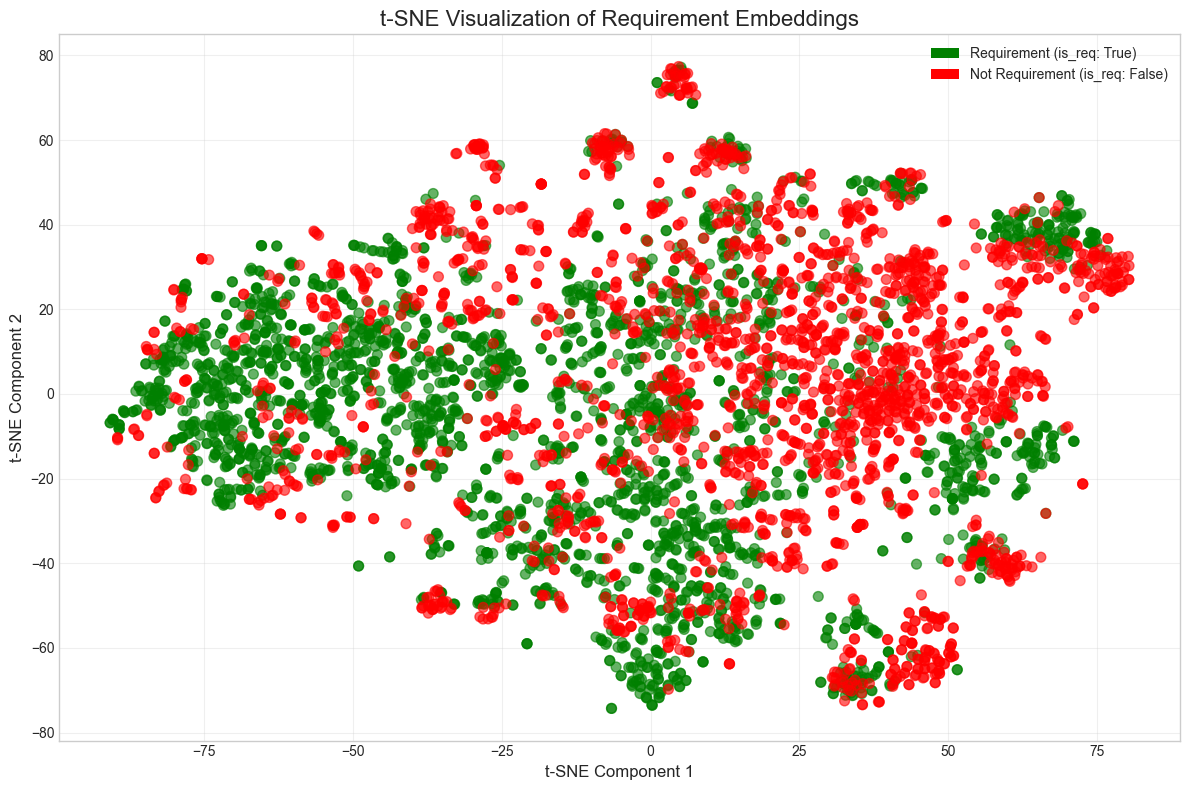

In [14]:
# Prepare colors based on metadata
colors = ['green' if meta['is_req'] else 'red' for meta in metadatas]

plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.6, s=50)
plt.title('t-SNE Visualization of Requirement Embeddings', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Requirement (is_req: True)'),
    Patch(facecolor='red', label='Not Requirement (is_req: False)')
]
plt.legend(handles=legend_elements, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()